![Banner](https://github.com/LittleHouse75/flatiron-resources/raw/main/NevitsBanner.png)

----

# Experiment: Random Address Split

----

## Overview (BLUF)

**Bottom line:** Under a random address split (no time drift), a tuned XGBoost model can separate scam vs. non-scam addresses extremely well (ROC AUC ≈ 0.998, AP ≈ 0.79), flagging a tiny set of addresses where ~80% of alerts are true scams.

In this experiment, we deliberately **ignore time** and use a **random split at the address level**. Training, validation, and test sets all come from the **same overall time span**.

Here we’re not trying to simulate “train on the past, predict the future.” Instead, we’re asking:

- When train and test come from the **same distribution** (the usual i.i.d. assumption), how well can the model separate scam vs. non-scam addresses?
- How much **signal** is present in the engineered address features under these stable conditions?
- What does performance look like when we are **not fighting time-based drift**, only the inherent structure of the problem?

This notebook is about **upper-bound performance under stable conditions**: it shows what the model can do when past and future look statistically similar, and it gives a clean contrast to the time-based experiment, where we deliberately break that assumption and see what degrades.

## 0. Notebook Setup

This section configures autoreload, imports core libraries, and connects the shared `src/` utilities so the rest of the notebook stays clean and focused.

In [1]:
# Enable autoreload so edits to src/*.py modules are picked up without restarting the kernel
%load_ext autoreload
%autoreload 2

# Make the project root importable so we can use src.utilities, src.featureeng, etc.
import os
import sys
import joblib

sys.path.append(os.path.abspath(".."))

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Scikit-learn utilities for splitting data + computing metrics
from sklearn.model_selection import train_test_split

# Project-specific utilities / modeling pipeline
import src.utilities as util
import src.featureeng as fe
import src.model_eval as me
from src import baselines
from src import tuning
from src.seed_util import SEED

# Consistent plotting style for the whole notebook
sns.set_style("whitegrid")

In [2]:
# ------------------------------------------------------------
# Load the raw Ethereum transaction dataset
#    (util.load_raw_data handles the path + basic logging)
# ------------------------------------------------------------

df = util.load_raw_data()


Loading Dataset

Reading dataset from (CSV): /Users/timnevits/Projects/PythonEnv311/flatiron/project-ethereum/data/Dataset.csv
Dataset loaded successfully with 71,250 rows and 18 columns.


## 1. Global Address Labels & Features (No Time Split)

Before we do any random splitting, we first build a **single, global view** of the data:

1. **Normalize timestamps** so every transaction has a clean UTC datetime and time-of-day features.
2. **Build address-level scam labels** (`Scam` = 1 if an address ever appears in scam-like activity anywhere in the dataset).
3. **Engineer address-level features** once, using **all transactions** and the global time span.

This gives us a **master feature table** `features_all` that we can later slice into Train/Validation/Test for the random split, without recomputing features each time.

In [3]:
# ------------------------------------------------------------
# Normalize timestamps and build global address labels
# ------------------------------------------------------------

util.print_heading("Address-Level Labels (Full Dataset, No Time Split)")

# Normalize raw timestamp strings into a clean UTC datetime
#     (adds block_timestamp_dt, hour, weekday, etc.)
df = fe.normalize_timestamps(df, verbose=True)

# Build a single global Scam label per address
#     (1 if the address is ever involved in scam-like activity)
addr_df = fe.build_address_labels(df, verbose=True)

# Define a global reference start time for all temporal features
global_start = df["block_timestamp_dt"].min()
if pd.isna(global_start):
    raise ValueError("Global start timestamp is NaT — check timestamp parsing.")
print("Global start timestamp:", global_start)

# ------------------------------------------------------------
# Engineer address-level features ONCE for all addresses
# ------------------------------------------------------------

features_all = fe.engineer_address_features(
    transaction_df=df,
    target_addresses=addr_df["Address"],
    addr_labels=addr_df,
    global_start=global_start,
    split_label="All Addresses",
    verbose=True,
)

print("Total addresses in features_all:", len(features_all))
print("Total scams:", int(features_all["Scam"].sum()))
print("Scam rate:", features_all["Scam"].mean())


Address-Level Labels (Full Dataset, No Time Split)


----------------------------------------
Timestamp normalization
----------------------------------------

Converting `block_timestamp` into a consistent UTC datetime and adding derived features (hour, weekday).
Value types in timestamp column:
block_timestamp
<class 'str'>    71250
Name: count, dtype: int64
Number of missing raw timestamp values: 0
Parsed timestamps (non-null): 71250
Unparseable timestamps: 0

----------------------------------------
Building Address-Level Scam Labels
----------------------------------------

Total addresses: 73034
Total scam addresses: 169
Global start timestamp: 2017-10-16 05:26:53+00:00

Preparing Transaction Data for Feature Engineering — All Addresses

Initial row count: 71250

----------------------------------------
Numeric Column Diagnostics
----------------------------------------

value: invalid=0
gas: invalid=0
gas_price: invalid=0
Numeric cleaning complete. Rows retained: 71250

-------

/Users/timnevits/Projects/PythonEnv311/flatiron/project-ethereum/src/featureeng.py:427: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  time_metrics = long_advanced.groupby("Address").apply(_compute_time_metrics)
/Users/timnevits/Projects/PythonEnv311/flatiron/project-ethereum/src/featureeng.py:440: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  burstiness = long_advanced.groupby("Address").apply(burst)



----------------------------------------
Gas-Based Features
----------------------------------------


Aligning Features to Target Address List


----------------------------------------
Final Feature Table Sample — All Addresses
----------------------------------------



,in_degree,out_degree,unique_in_degree,unique_out_degree,Tx count,Avg amount incoming,Total amount incoming,Max amount incoming,Min amount incoming,Avg amount outgoing,...,Hour entropy,Incoming count,Outgoing count,Last seen,Activity Density,In/Out Ratio,Recency,Avg gas price,Avg gas limit,Scam
Address,,,,,,,,,,,,,,,,,,,,,
0x267be1c1d684f78cb4f6a176c4911b741e4ffdc0,1,1701,1,1567,1702,1.000000e+16,1.000000e+16,1.000000e+16,1.000000e+16,1.106280e+19,...,4.442918,1,1701,52103991.0,0.000033,0.001175,17475416.0,6.459977e+10,31551.116334,0
0x304cc179719bc5b05418d6f7f6783abe45d83090,189,126,189,116,315,2.987973e+17,5.647270e+19,3.190000e+19,4.079820e+12,2.405875e+17,...,3.757143,189,126,11749488.0,0.000027,1.496063,57829919.0,7.040660e+09,48600.000000,0
0x323b10c39732f689a4763fbeebc2347a24b863e2,0,1,0,1,1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.960000e+16,...,-0.000000,0,1,283.0,1.000000,0.500000,69579124.0,2.060947e+10,21000.000000,0
0x44de2e2b1f378d51e0d2a2ae5ebe4d427ab955a9,80,386,80,343,466,2.340084e+18,1.872067e+20,1.020000e+20,3.470000e+16,2.282073e+17,...,4.502845,80,386,1257200.0,0.000371,0.209302,68322207.0,6.430423e+09,103832.618026,0
0xd063435d7cab1a792e1d56f7aab04313b3d87179,0,23,0,23,23,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.647826e+18,...,2.381774,0,23,730529.0,0.000031,0.041667,68848878.0,6.110000e+10,42000.000000,0


Total addresses in this split: 73034
Total scam labels: 169
Total addresses in features_all: 73034
Total scams: 169
Scam rate: 0.002313990744037024


## 2. Random Train/Validation/Test Split (Address-Level)

Now that we have a single global feature table (`features_all`), we do a **random split at the address level**:

- We stratify on the `Scam` label so the scam rate is similar in Train+Val and Test.
- All splits come from the **same time span** — there is **no time-based separation** here.
- The goal is to measure **upper-bound performance** when Train and Test are i.i.d. from the same distribution.

The result is:

- `features_trainval`: addresses used for model training and validation  
- `features_test`: held-out addresses used **only** for final evaluation in this random-split experiment

In [4]:
# ------------------------------------------------------------
# Random Train+Val / Test Split (Address-Level, Stratified)
# ------------------------------------------------------------

util.print_heading("Random Train+Val / Test Split (Address-Level)")

TARGET_COL = "Scam"

# Address index + labels from the global feature table
addrs_all  = features_all.index
labels_all = features_all[TARGET_COL]

# Stratified random split so scam rate is similar in both splits
trainval_addrs, test_addrs = train_test_split(
    addrs_all,
    test_size=0.2,      # could be 0.15 if we want a smaller test set
    stratify=labels_all,
    random_state=SEED,
)

# Slice the global feature table into Train+Val and Test
features_trainval = features_all.loc[trainval_addrs].copy()
features_test     = features_all.loc[test_addrs].copy()

print("Train+Val addresses:", len(features_trainval))
print("Test addresses:", len(features_test))
print("Train+Val scam rate:", features_trainval[TARGET_COL].mean())
print("Test scam rate:", features_test[TARGET_COL].mean())


Random Train+Val / Test Split (Address-Level)

Train+Val addresses: 58427
Test addresses: 14607
Train+Val scam rate: 0.002310575590052544
Test scam rate: 0.002327651126172383


## 3. Persist Random-Split Feature Tables

To keep this experiment reproducible (and decouple it from upstream notebooks),  
we save the engineered features for:

- `features_trainval` → used for model training + validation  
- `features_test` → used only for final evaluation in this random-split setup  

These CSVs can be reloaded later without having to recompute all address-level
features from the raw transaction data.

In [5]:
# ------------------------------------------------------------
# Save Random-Split Feature Tables to disk
# ------------------------------------------------------------

features_trainval_name = "random_split_trainval"
features_test_name     = "random_split_test"

util.save_data(features_trainval, features_trainval_name, index=True)
util.save_data(features_test,     features_test_name,     index=True)


Saving Dataset

Writing CSV dataset to: /Users/timnevits/Projects/PythonEnv311/flatiron/project-ethereum/data/random_split_trainval.csv
CSV saved with 58,427 rows and 32 columns.
Writing Parquet dataset to: /Users/timnevits/Projects/PythonEnv311/flatiron/project-ethereum/data/random_split_trainval.parquet
Parquet saved.

Saving Dataset

Writing CSV dataset to: /Users/timnevits/Projects/PythonEnv311/flatiron/project-ethereum/data/random_split_test.csv
CSV saved with 14,607 rows and 32 columns.
Writing Parquet dataset to: /Users/timnevits/Projects/PythonEnv311/flatiron/project-ethereum/data/random_split_test.parquet
Parquet saved.


## 4. Baseline Models — Random Address Split

With the random Train+Val / Test address split in place, we now train a small
set of **baseline classifiers** (Logistic Regression, RandomForest, ExtraTrees,
XGBoost) on the engineered features.

This step answers:

- How well do standard models separate scam vs. non-scam addresses under a
  **stable, i.i.d. random split**?
- Which model families look most promising before any serious tuning?

We report metrics separately on **Train**, **Validation**, and **Test** so it’s
easy to see overfitting and generalization behavior.


Baseline Models — Random Address Split


Train / Validation Split (Within Train+Val Addresses)

Train+Val shape: (58427, 31)
Test shape:      (14607, 31)
Train+Val positives: 135
Train+Val negatives: 58292
Test positives:       34
Test negatives:       14573

Train size: 46741
Val size:   11686
Test size:  14607

Scaling Numeric Features (for Linear/NN Models)


Defining Baseline Models

XGBoost baseline defined.

Running Baseline Models


----------------------------------------
Fitting LogisticRegression
----------------------------------------

Scoring on Train / Val / Test...
LogisticRegression — Validation metrics:
  val_accuracy: 0.9499
  val_precision: 0.0411
  val_recall: 0.9259
  val_f1: 0.0787
  val_roc_auc: 0.9540
  val_avg_precision: 0.3181
Confusion matrix (val):
[[11076   583]
 [    2    25]]


Full Evaluation — LogisticRegression (Test Split)


=== Evaluation for: LogisticRegression — Test ===
threshold = 0.5
Accuracy:  0.9482
Precision: 0.0419
Recall:    0.9706
F1:    

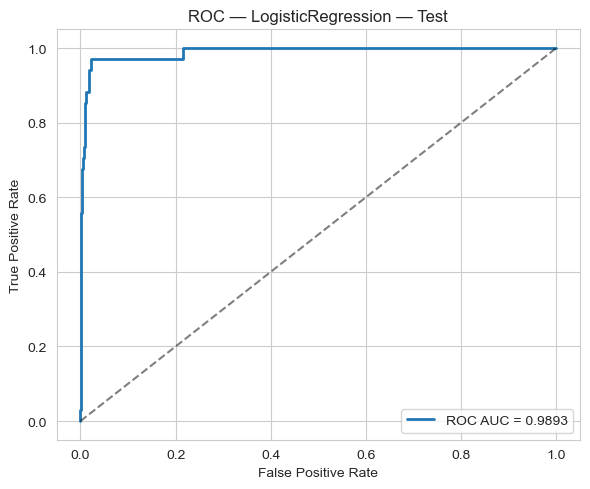

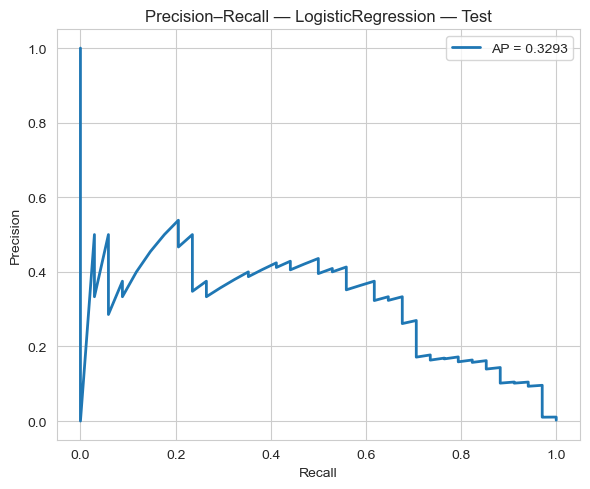

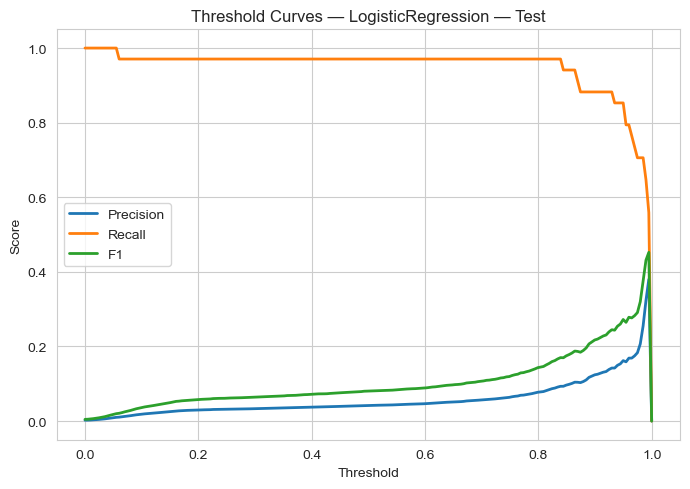

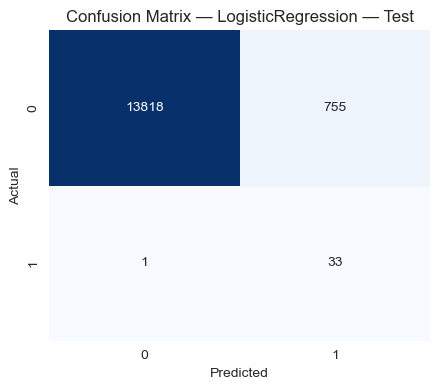

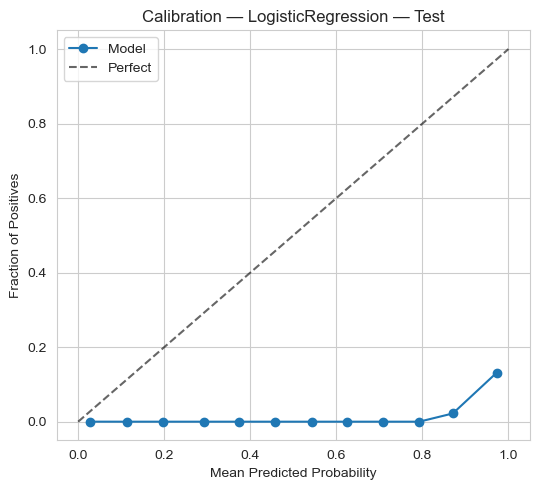


----------------------------------------
Fitting RandomForest
----------------------------------------

Scoring on Train / Val / Test...
RandomForest — Validation metrics:
  val_accuracy: 0.9985
  val_precision: 0.8462
  val_recall: 0.4074
  val_f1: 0.5500
  val_roc_auc: 0.9989
  val_avg_precision: 0.7661
Confusion matrix (val):
[[11657     2]
 [   16    11]]


Full Evaluation — RandomForest (Test Split)


=== Evaluation for: RandomForest — Test ===
threshold = 0.5
Accuracy:  0.9986
Precision: 0.9333
Recall:    0.4118
F1:        0.5714
ROC AUC:   0.9979
Avg Precision (AP): 0.7202


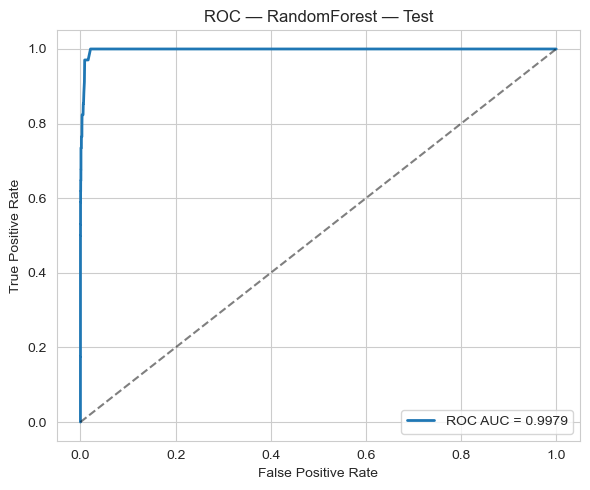

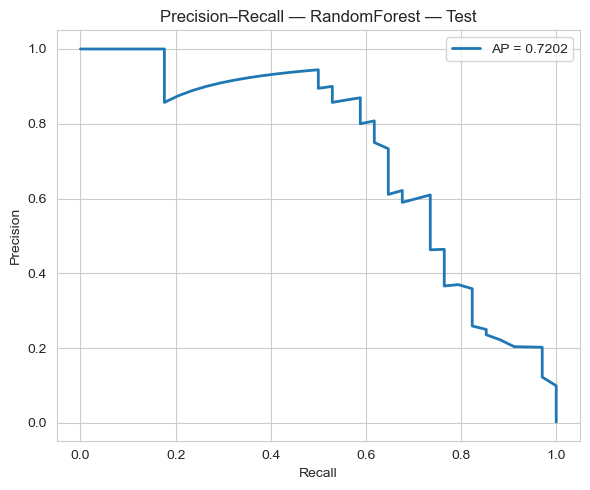

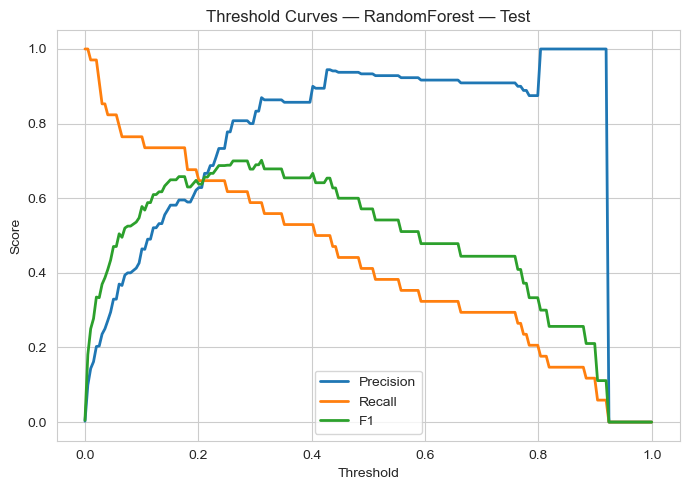

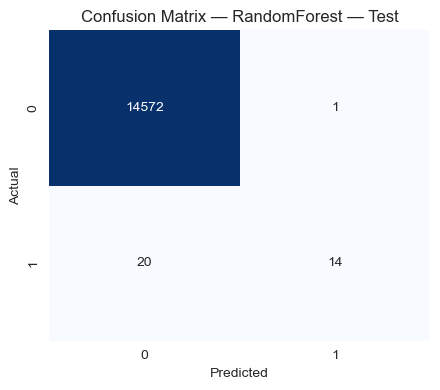

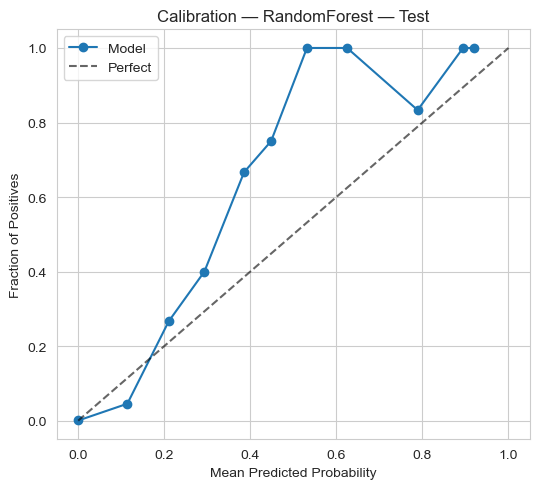


----------------------------------------
Fitting ExtraTrees
----------------------------------------

Scoring on Train / Val / Test...
ExtraTrees — Validation metrics:
  val_accuracy: 0.9985
  val_precision: 0.8462
  val_recall: 0.4074
  val_f1: 0.5500
  val_roc_auc: 0.9990
  val_avg_precision: 0.7507
Confusion matrix (val):
[[11657     2]
 [   16    11]]


Full Evaluation — ExtraTrees (Test Split)


=== Evaluation for: ExtraTrees — Test ===
threshold = 0.5
Accuracy:  0.9985
Precision: 0.9286
Recall:    0.3824
F1:        0.5417
ROC AUC:   0.9980
Avg Precision (AP): 0.7482


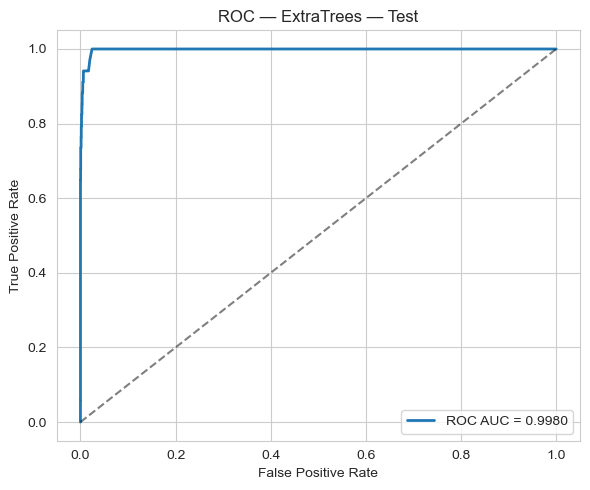

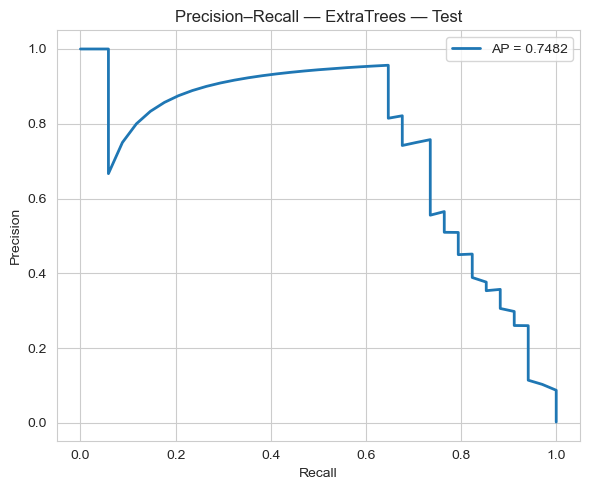

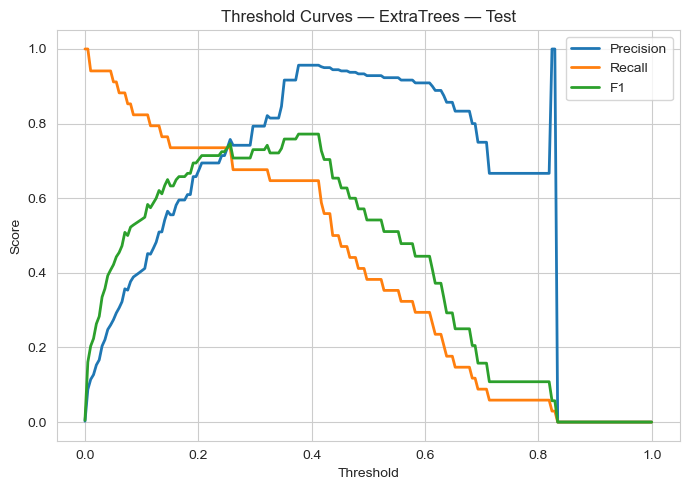

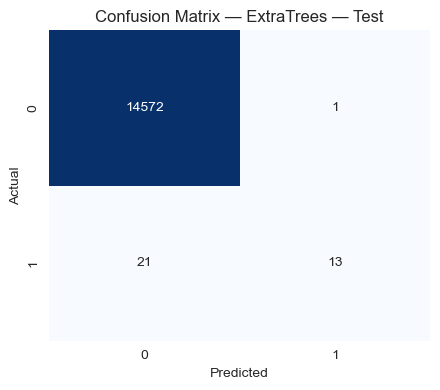

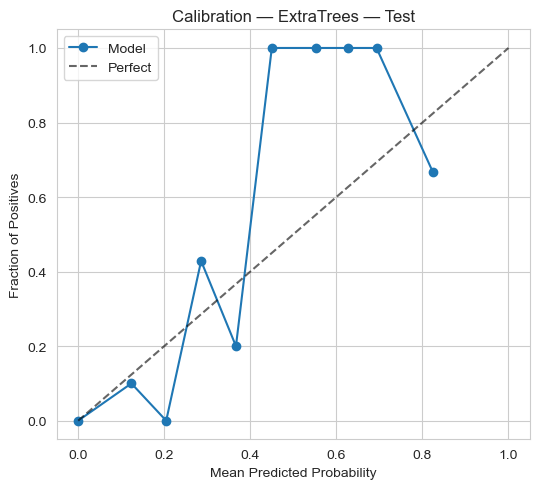


----------------------------------------
Fitting XGBoost
----------------------------------------

Scoring on Train / Val / Test...
XGBoost — Validation metrics:
  val_accuracy: 0.9984
  val_precision: 0.6176
  val_recall: 0.7778
  val_f1: 0.6885
  val_roc_auc: 0.9987
  val_avg_precision: 0.7878
Confusion matrix (val):
[[11646    13]
 [    6    21]]


Full Evaluation — XGBoost (Test Split)


=== Evaluation for: XGBoost — Test ===
threshold = 0.5
Accuracy:  0.9986
Precision: 0.6585
Recall:    0.7941
F1:        0.7200
ROC AUC:   0.9983
Avg Precision (AP): 0.7825


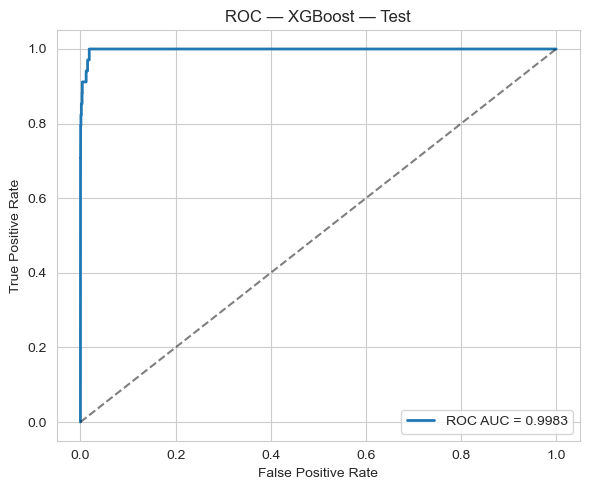

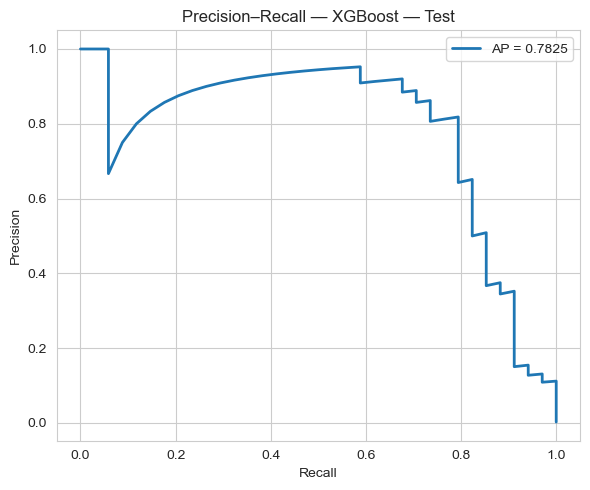

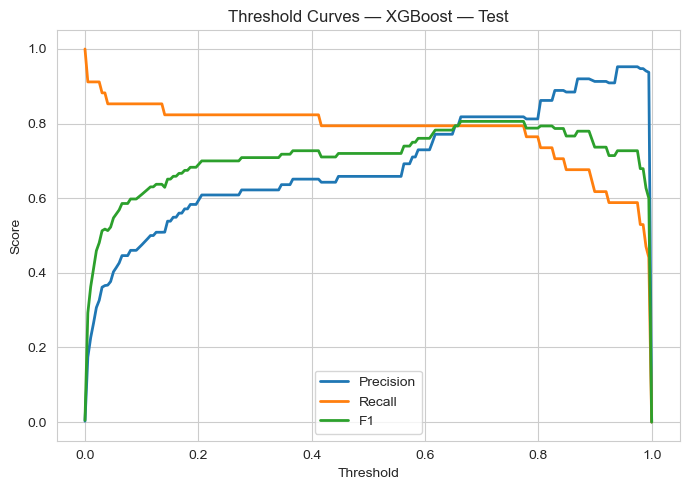

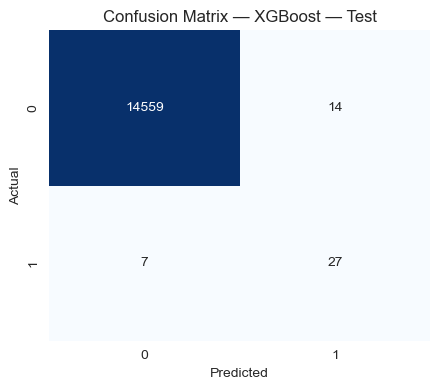

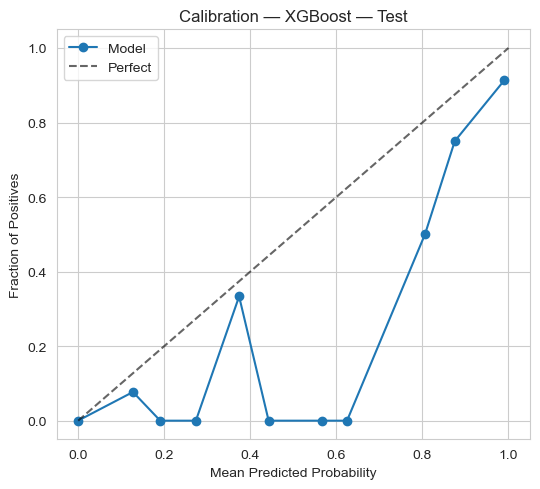


----------------------------------------
Fitting MLP
----------------------------------------

Scoring on Train / Val / Test...
MLP — Validation metrics:
  val_accuracy: 0.9982
  val_precision: 0.6500
  val_recall: 0.4815
  val_f1: 0.5532
  val_roc_auc: 0.9963
  val_avg_precision: 0.5179
Confusion matrix (val):
[[11652     7]
 [   14    13]]


Full Evaluation — MLP (Test Split)


=== Evaluation for: MLP — Test ===
threshold = 0.5
Accuracy:  0.9983
Precision: 0.6800
Recall:    0.5000
F1:        0.5763
ROC AUC:   0.9908
Avg Precision (AP): 0.4971


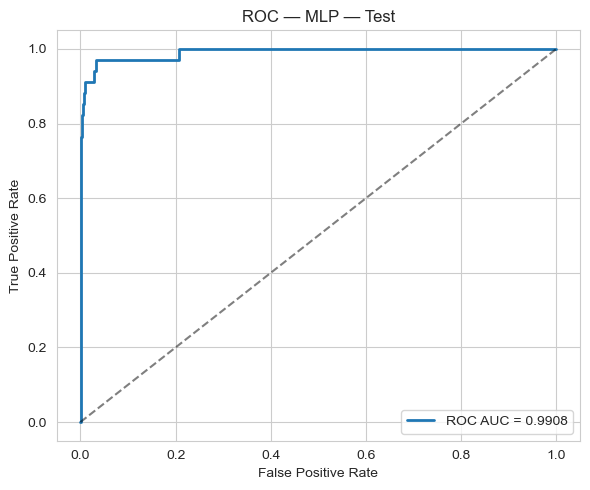

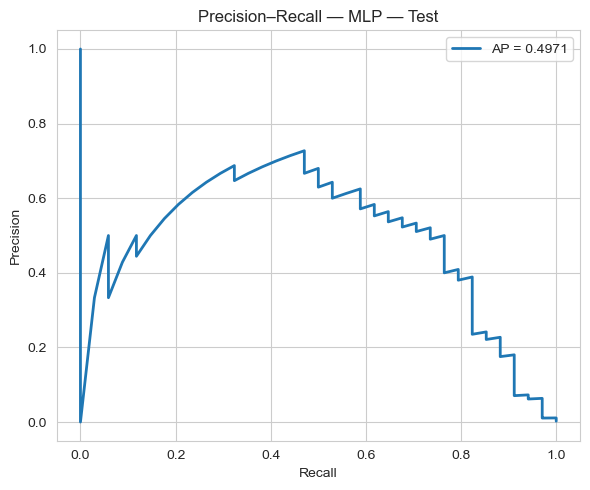

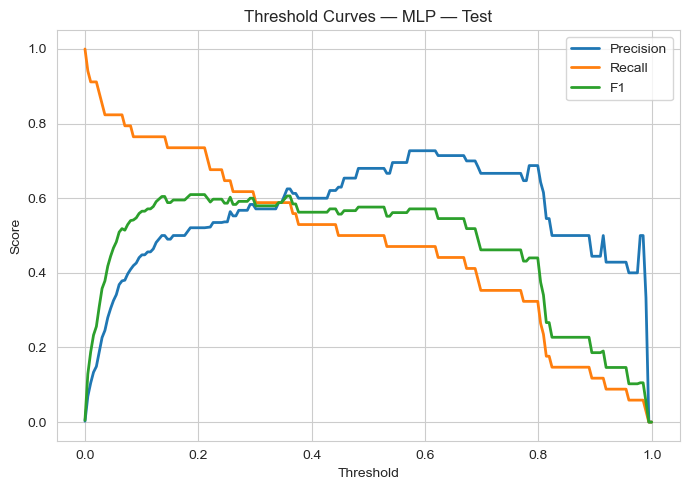

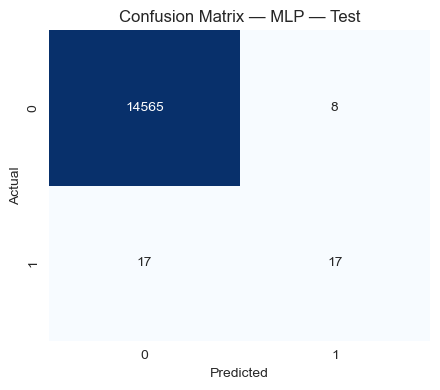

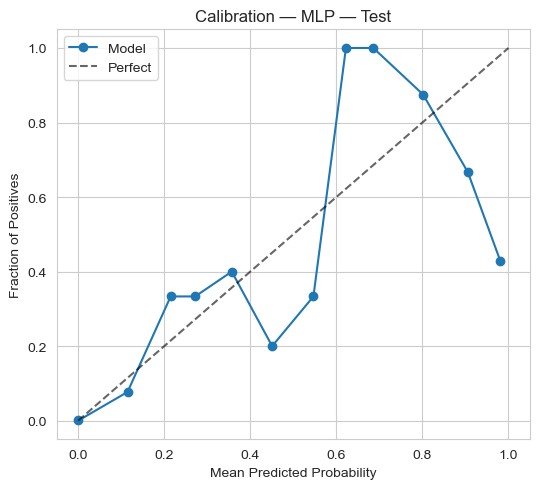


----------------------------------------
Training Metrics by Model
----------------------------------------



,model,accuracy,precision,recall,f1,roc_auc,avg_precision
0,RandomForest,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,XGBoost,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,ExtraTrees,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,MLP,0.998674,0.819444,0.546296,0.655556,0.992538,0.677161
4,LogisticRegression,0.950622,0.042429,0.944444,0.081210,0.987371,0.368525



----------------------------------------
Validation Metrics by Model
----------------------------------------



,model,accuracy,precision,recall,f1,roc_auc,avg_precision
0,XGBoost,0.998374,0.617647,0.777778,0.688525,0.998723,0.787794
1,RandomForest,0.998460,0.846154,0.407407,0.550000,0.998874,0.766114
2,ExtraTrees,0.998460,0.846154,0.407407,0.550000,0.999026,0.750734
3,MLP,0.998203,0.650000,0.481481,0.553191,0.996344,0.517864
4,LogisticRegression,0.949940,0.041118,0.925926,0.078740,0.953954,0.318113



----------------------------------------
Test Metrics by Model
----------------------------------------



,model,accuracy,precision,recall,f1,roc_auc,avg_precision
0,XGBoost,0.998562,0.658537,0.794118,0.720000,0.998270,0.782468
1,ExtraTrees,0.998494,0.928571,0.382353,0.541667,0.998046,0.748220
2,RandomForest,0.998562,0.933333,0.411765,0.571429,0.997942,0.720198
3,MLP,0.998288,0.680000,0.500000,0.576271,0.990754,0.497066
4,LogisticRegression,0.948244,0.041878,0.970588,0.080292,0.989271,0.329293


In [6]:
# ------------------------------------------------------------
# Run baseline models on random-split features
# ------------------------------------------------------------

util.print_heading("Baseline Models — Random Address Split")

results_random, train_random, val_random, test_random, scaler_random = baselines.run_baselines(
    features_trainval,
    features_test,
    target_col="Scam",
    do_full_eval=True,   # also generates ROC/PR/threshold plots on the chosen eval split
    eval_split="test",
)

# Separate views for each split to make overfitting / generalization obvious
util.print_sub_heading("Training Metrics by Model")
display(train_random)

util.print_sub_heading("Validation Metrics by Model")
display(val_random)

util.print_sub_heading("Test Metrics by Model")
display(test_random)

### Baseline Takeaways — Random Address Split

---

### 1. Under a random split, the signal is very strong

With addresses randomly (and stratified) split between Train+Val and Test, all models achieve **very high ranking performance**: ROC AUC ≈ 0.99–0.998 and Average Precision far above the base rate (~0.23% scams).  
**Implication:**  
The engineered address-level features carry **strong, stable signal** when train and test share the same distribution. This experiment is a reasonable **upper bound** on what the models can do.

---

### 2. Logistic regression is a good ranker but a blunt classifier

LogisticRegression reaches ROC AUC ≈ 0.99 and AP ≈ 0.33, but at the default 0.5 threshold it trades precision for recall (Precision ≈ 4%, Recall ≈ 97%).  
**Implication:**  
LogReg works best as a **score / ranking model** (for sorting or very low-threshold alerting), not as a strict “scam / not scam” classifier at 0.5.

---

### 3. Tree ensembles act as high-precision filters (and memorize the train set)

RandomForest and ExtraTrees both deliver ROC AUC ≈ 0.998 and AP ≈ 0.72–0.75. On the **training set** they are essentially perfect (accuracy / precision / recall / AP ≈ 1.0), which is classic “memorize the positives” behavior for flexible trees on a rare-event task. On validation and test they stay very precise (≈93%) but only catch ~40% of scams.  
**Implication:**  
These models behave like **precision-first filters**: when they say “scam,” they are usually right, but they will miss a non-trivial share of scams unless the threshold is lowered. The perfect train scores are expected given capacity and class imbalance, not a red flag by themselves.

---

### 4. XGBoost gives the best overall trade-off

XGBoost is the strongest baseline: ROC AUC ≈ 0.998, AP ≈ 0.78, with a more balanced precision–recall profile at 0.5 (Precision ≈ 0.66, Recall ≈ 0.79, F1 ≈ 0.72). It also hits perfect metrics on the training set, then generalizes slightly better than the other trees on validation and test.  
**Implication:**  
For this random-split setting, XGBoost is the **default choice**: it captures most scams while keeping false positives manageable, and it provides a solid reference point for later tuning.

---

### 5. Validation and test metrics are consistent despite overfitting on train

Even though the tree ensembles (RF / ExtraTrees / XGBoost) perfectly fit the training set, their **validation and test** scores stay closely aligned and very high. There is no collapse in performance when we move off the training data.  
**Implication:**  
The random address split and modeling pipeline look **well-calibrated and stable** under i.i.d. conditions. Performance differences between this notebook and the time-split notebook can be attributed to **distribution shift over time**, not to flaws in the baseline setup here.

## 5. Hyperparameter Tuning — Random Address Split

In the baseline step, **tree-based models** clearly dominated: RandomForest, ExtraTrees, and XGBoost all achieved very high ROC AUC and Average Precision, with XGBoost leading overall.  

Here we focus our tuning effort on **those three ensembles** because:

- They already **outperform** the linear baseline (LogisticRegression) on ranking metrics.
- Trees naturally capture **nonlinear interactions** in our engineered features (amounts, timing, gas, degree).
- They are the most realistic candidates for a **production fraud model** in this setting.

The goal is not to reinvent the models, but to see whether **RandomizedSearchCV** can find configurations that:
- Preserve their very strong ranking power, and  
- Improve the **precision–recall balance** at the default threshold.


Hyperparameter Tuning — Random Address Split


Train / Validation Split for Tuning

Train+Val shape: (58427, 31)
Test shape:      (14607, 31)
Train+Val positives: 135
Train+Val negatives: 58292
Test positives:       34
Test negatives:       14573

Train size: 46741
Val size:   11686
Test size:  14607

Scaling (for any scaled models, if added later)


Defining Random Search Spaces


Running RandomizedSearchCV


----------------------------------------
Tuning XGBoost
----------------------------------------

Fitting 3 folds for each of 45 candidates, totalling 135 fits
[CV] END colsample_bytree=0.9754210836063001, gamma=0.00038938292050716417, learning_rate=0.054610577964560876, max_depth=3, min_child_weight=4, n_estimators=613, scale_pos_weight=20.779485966621912, subsample=0.6028265220878869; total time=   1.4s
[CV] END colsample_bytree=0.749816047538945, gamma=0.4753571532049581, learning_rate=0.04159969709057025, max_depth=7, min_child_weight=7, n_estimators=421, scale_pos_weight=43

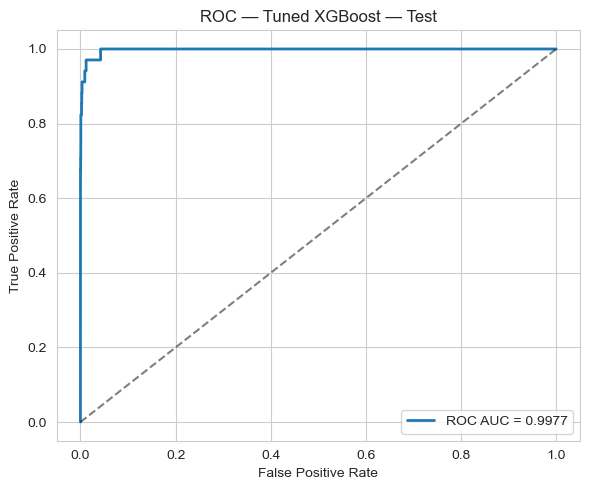

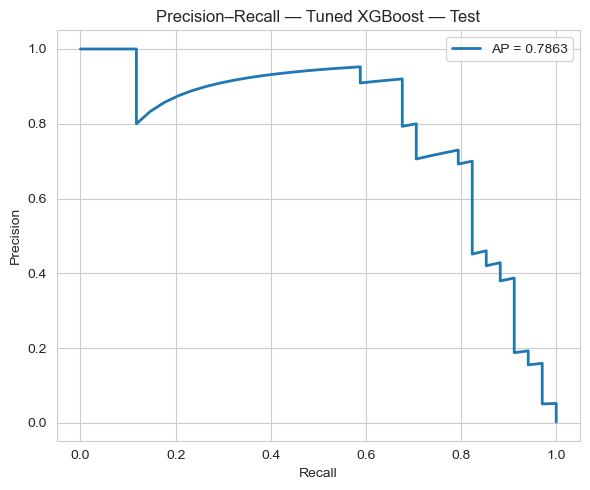

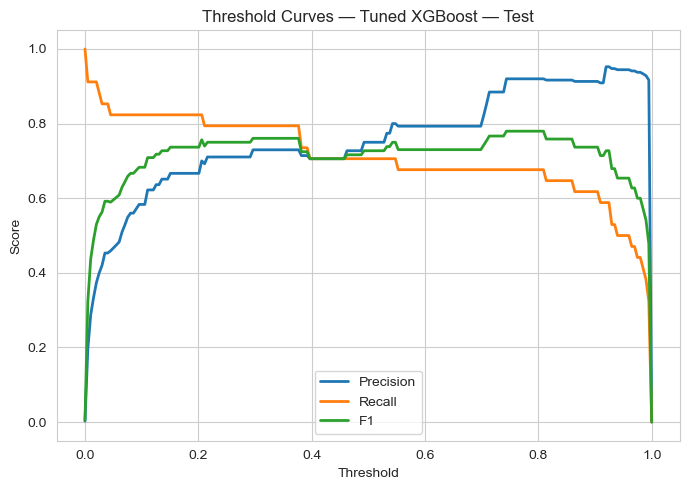

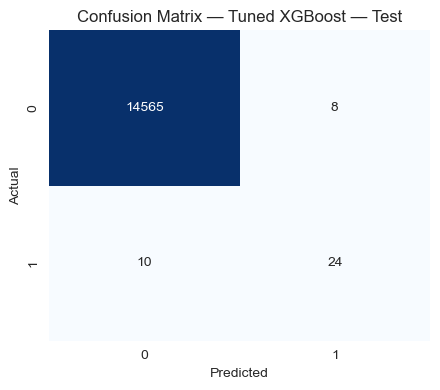

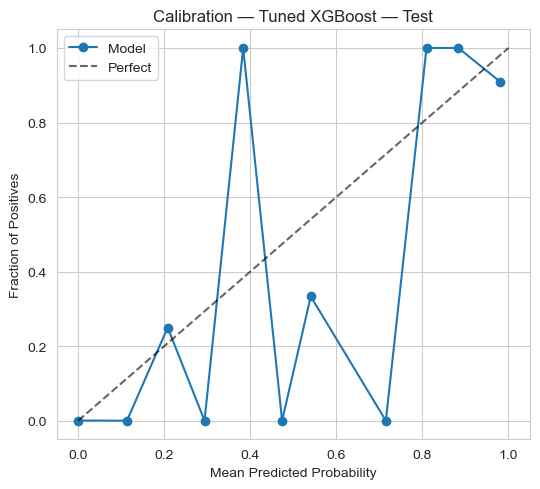


----------------------------------------
Plots for Tuned RandomForest (Test)
----------------------------------------


=== Evaluation for: Tuned RandomForest — Test ===
threshold = 0.5
Accuracy:  0.9987
Precision: 0.8571
Recall:    0.5294
F1:        0.6545
ROC AUC:   0.9970
Avg Precision (AP): 0.6935


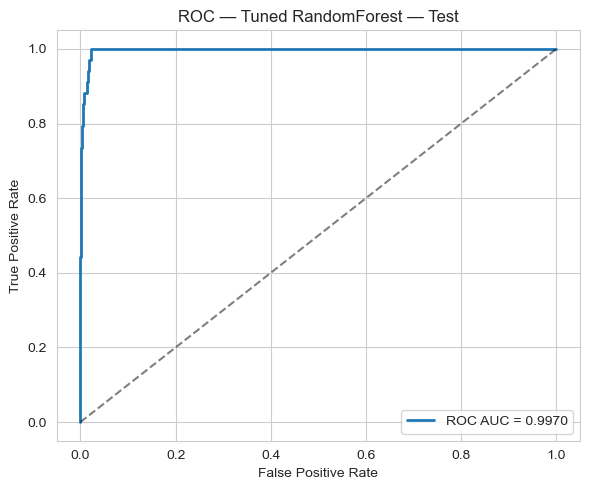

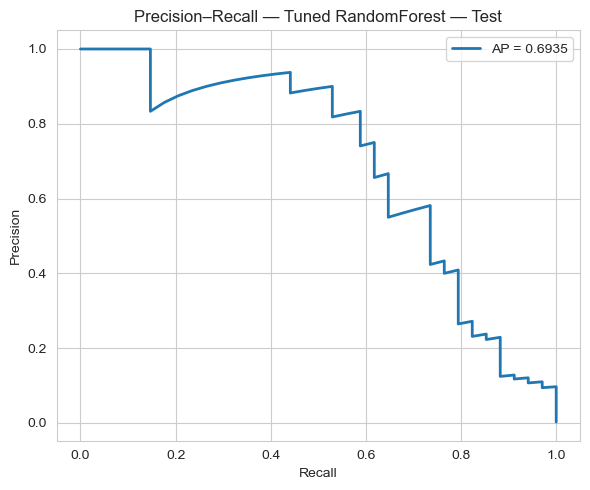

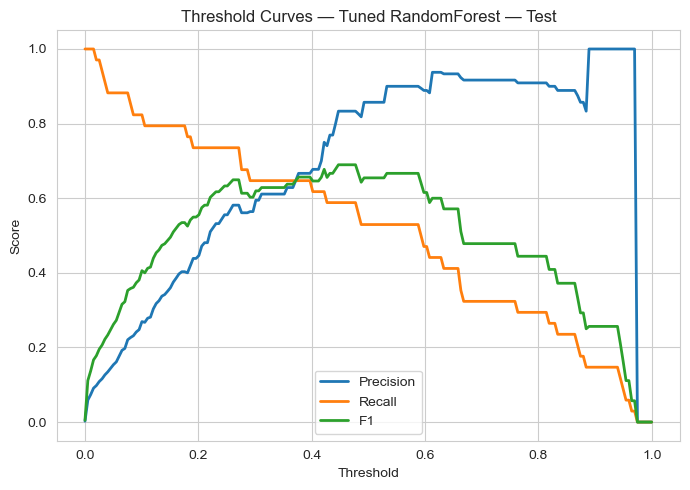

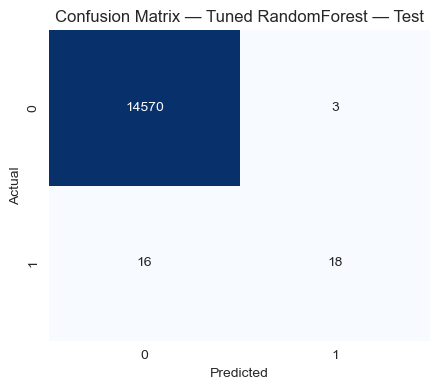

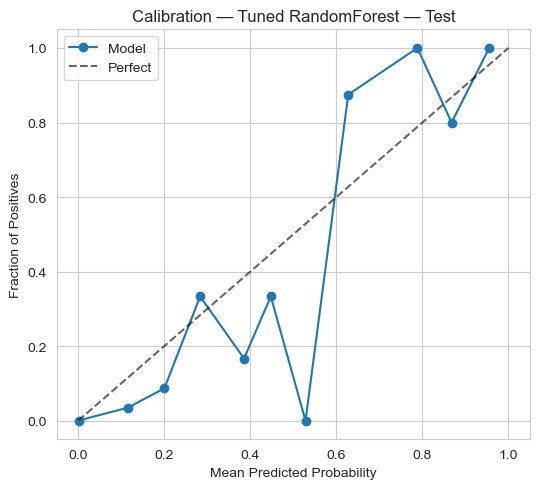


----------------------------------------
Plots for Tuned ExtraTrees (Test)
----------------------------------------


=== Evaluation for: Tuned ExtraTrees — Test ===
threshold = 0.5
Accuracy:  0.9988
Precision: 0.8148
Recall:    0.6471
F1:        0.7213
ROC AUC:   0.9974
Avg Precision (AP): 0.6780


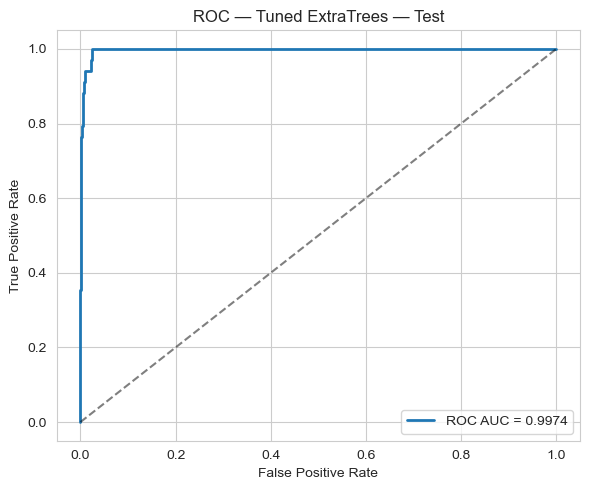

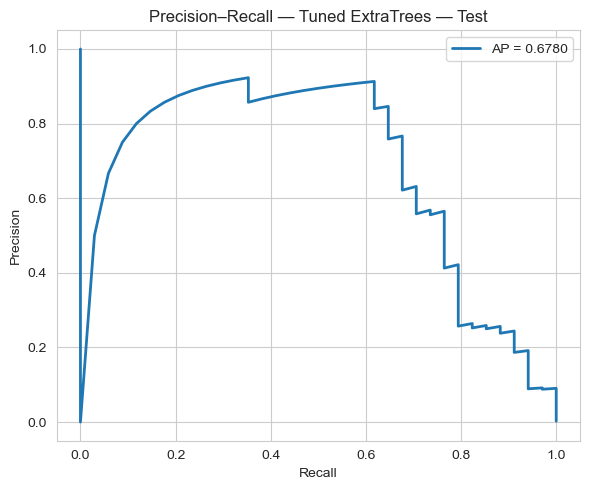

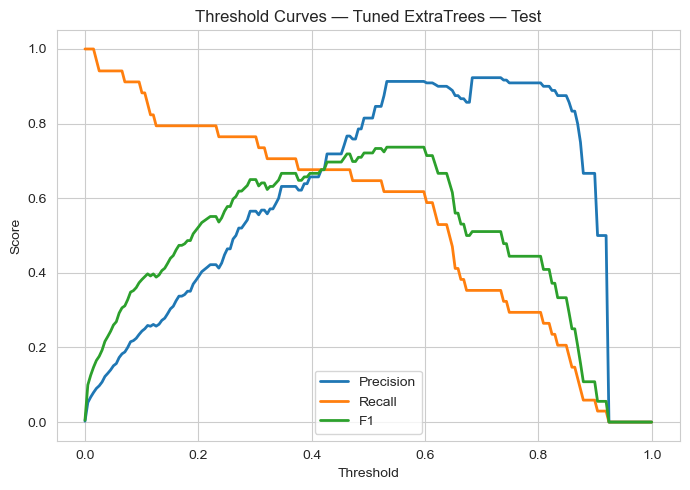

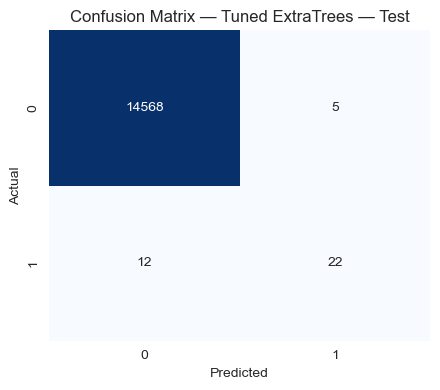

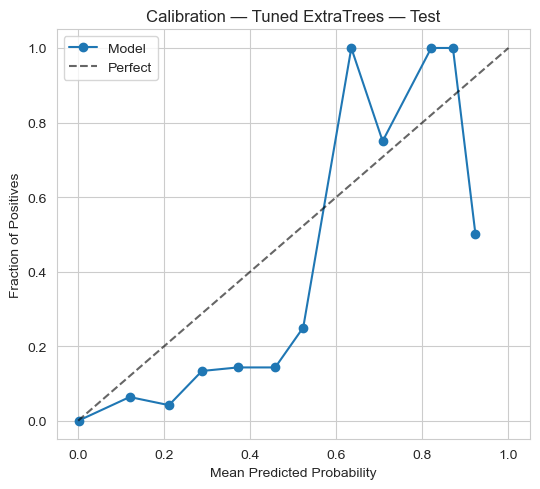


----------------------------------------
Training Metrics by Model (Tuned)
----------------------------------------



,model,accuracy,precision,recall,f1,roc_auc,avg_precision
0,XGBoost,1.000000,1.000000,1.0,1.000000,1.0,1.0
1,RandomForest,0.999914,0.964286,1.0,0.981818,1.0,1.0
2,ExtraTrees,0.999872,0.947368,1.0,0.972973,1.0,1.0



----------------------------------------
Validation Metrics by Model (Tuned)
----------------------------------------



,model,accuracy,precision,recall,f1,roc_auc,avg_precision
0,XGBoost,0.998460,0.655172,0.703704,0.678571,0.998939,0.788146
1,RandomForest,0.998374,0.666667,0.592593,0.627451,0.998262,0.737864
2,ExtraTrees,0.998460,0.736842,0.518519,0.608696,0.998828,0.727696



----------------------------------------
Test Metrics by Model (Tuned)
----------------------------------------



,model,accuracy,precision,recall,f1,roc_auc,avg_precision
0,XGBoost,0.998768,0.750000,0.705882,0.727273,0.997744,0.786316
1,RandomForest,0.998699,0.857143,0.529412,0.654545,0.997041,0.693514
2,ExtraTrees,0.998836,0.814815,0.647059,0.721311,0.997419,0.677982


In [7]:
# ------------------------------------------------------------
# Hyperparameter tuning — tree ensembles on random split
#    (RandomForest, ExtraTrees, XGBoost)
# ------------------------------------------------------------

util.print_heading("Hyperparameter Tuning — Random Address Split")

best_random, train_random_tuned, val_random_tuned, test_random_tuned, \
    search_spaces_random, scaler_random_tuned = tuning.run_tuning(
        features_trainval,
        features_test,
        target_col="Scam",
        threshold=0.5,      # eval at 0.5 here; later we do explicit threshold tuning
        do_full_eval=True,  # plot ROC / PR / calibration for tuned models
        eval_split="test",  # full diagnostics on the held-out test set
    )

util.print_sub_heading("Training Metrics by Model (Tuned)")
display(train_random_tuned)

util.print_sub_heading("Validation Metrics by Model (Tuned)")
display(val_random_tuned)

util.print_sub_heading("Test Metrics by Model (Tuned)")
display(test_random_tuned)

### Hyperparameter Tuning Takeaways — Random Address Split

---

### 1. Why tune these three models?

We restricted tuning to **RandomForest, ExtraTrees, and XGBoost** because they were already the **strongest baselines** in the random-split setting (ROC AUC ≈ 0.998, AP ≫ base rate).  
**Implication:**  
Tuning time is focused on the models most likely to end up as real candidates, rather than spreading effort across weaker baselines.

---

### 2. Tuning confirms the trees, rather than transforming them

After RandomizedSearchCV, all three trees keep **ROC AUC ≈ 0.997–0.998** and **AP in the same band** as their baselines (XGBoost AP ≈ 0.79, RandomForest ≈ 0.69, ExtraTrees ≈ 0.68).  
**Implication:**  
The original settings were already in a good regime. Tuning delivers **small refinements**, not a new class of model.

---

### 3. Threshold behavior improves more than headline metrics

On the held-out test set at threshold 0.5:

- **XGBoost:** Precision climbs (≈0.66 → ≈0.75) with a modest recall trade-off (≈0.79 → ≈0.71), lifting F1 from ≈0.72 to ≈0.73.  
- **RandomForest / ExtraTrees:** Move from “extreme precision / low recall” toward more balanced F1 in the ≈0.65–0.72 range.

**Implication:**  
Scoring by **average precision** mainly finds configs with a **cleaner precision–recall trade-off at 0.5**, especially for the tree ensembles.

---

### 4. XGBoost remains the best all-around model

Among the tuned models, XGBoost offers:

- The **highest AP** on test (~0.79),  
- Excellent ROC AUC (~0.998),  
- The most balanced precision/recall at 0.5 (≈75% precision, ≈71% recall, F1 ≈ 0.73).

**Implication:**  
Under random-split conditions, tuned XGBoost is the **primary production candidate**; RandomForest and ExtraTrees are strong backups at nearby precision/recall trade-offs.

---

### 5. Perfect train scores are expected, not alarming

All tree ensembles essentially memorize the rare positives on Train+Val (AP and ROC AUC ≈ 1.0), but **validation and test metrics stay high and aligned**.  
**Implication:**  
Given the tiny positive class and flexible trees, “perfect” train metrics are normal. We judge models by **validation/test behavior**, not by the overfit training scores.

---

### 6. The tuning pipeline is methodologically sound

The setup uses:

- **Address-level stratified Train/Val/Test**,  
- RandomizedSearchCV scored on **average precision** (rare-event friendly),  
- **Imbalance-aware settings** (`class_weight="balanced"` / `scale_pos_weight`),  
- A **clean separation** between tuning and the final test evaluation.

**Implication:**  
This is a **defensible hyperparameter search design** for imbalanced fraud detection, and it gives a solid, high-performing reference point for comparing against the time-based split.

## 6. XGBoost Narrow Hyperparameter Search

Here we zoom in on **XGBoost only**, running a tighter hyperparameter search around the good region found earlier. The goal is to check how **robust** performance is within this band and see whether a more regularized, “sane” configuration can match or beat our earlier tuned XGBoost on the random address split.


XGBoost Narrow Hyperparameter Search — Random Split


XGBoost Narrow Hyperparameter Search

Train+Val shape: (58427, 31)
Test shape:      (14607, 31)
Train+Val positives: 135
Train+Val negatives: 58292
Test positives:       34
Test negatives:       14573

Running narrowed XGBoost random search...
Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV] END colsample_bytree=0.8123620356542087, gamma=0.9507143064099162, learning_rate=0.1178392730173686, max_depth=10, min_child_weight=5, n_estimators=402, reg_alpha=0.22291637642679557, reg_lambda=0.6499623737270044, subsample=0.8377746675897602; total time=   0.7s
[CV] END colsample_bytree=0.8123620356542087, gamma=0.9507143064099162, learning_rate=0.1178392730173686, max_depth=10, min_child_weight=5, n_estimators=402, reg_alpha=0.22291637642679557, reg_lambda=0.6499623737270044, subsample=0.8377746675897602; total time=   0.8s
[CV] END colsample_bytree=0.8123620356542087, gamma=0.9507143064099162, learning_rate=0.1178392730173

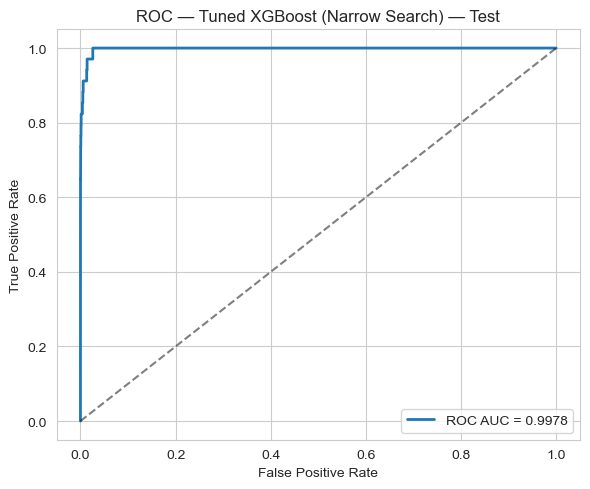

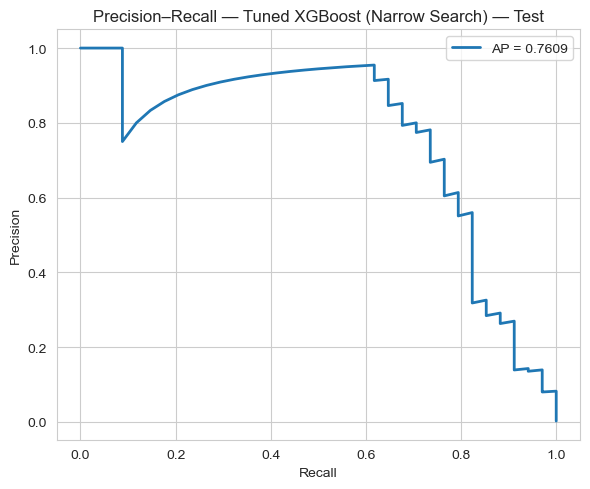

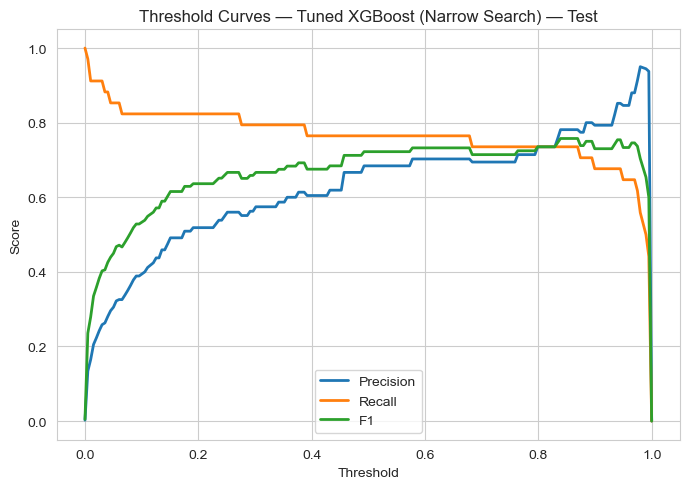

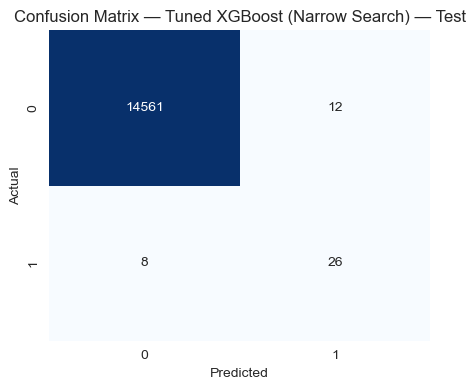

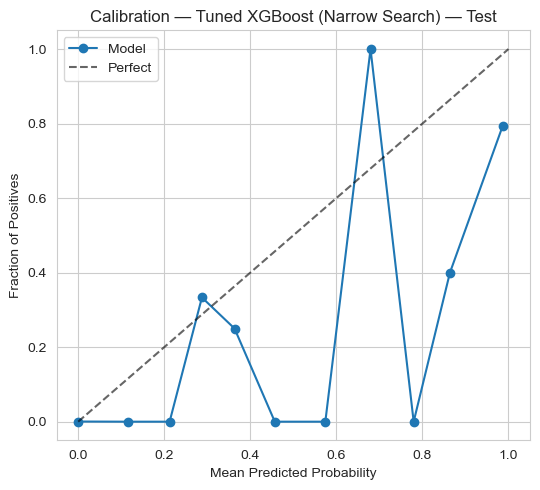


----------------------------------------
Training Metrics — XGBoost (Narrow Search)
----------------------------------------



,model,accuracy,precision,recall,f1,roc_auc,avg_precision
0,XGBoost (Narrow),0.999914,0.964286,1.0,0.981818,1.0,1.0



----------------------------------------
Validation Metrics — XGBoost (Narrow Search)
----------------------------------------



,model,accuracy,precision,recall,f1,roc_auc,avg_precision
0,XGBoost (Narrow),0.998032,0.555556,0.740741,0.634921,0.998548,0.748317



----------------------------------------
Test Metrics — XGBoost (Narrow Search)
----------------------------------------



,model,accuracy,precision,recall,f1,roc_auc,avg_precision
0,XGBoost (Narrow),0.998631,0.684211,0.764706,0.722222,0.997822,0.760874


In [8]:
# ------------------------------------------------------------
# XGBoost-only narrow hyperparameter search on Random Split
# 
# At this point we’ve already:
#   - Tuned all three tree models (RF, ExtraTrees, XGBoost) broadly.
#   - Identified XGBoost as the best overall performer.
#
# This step zooms in on XGBoost alone with a tighter search space to:
#   - Check how robust performance is within a “reasonable” region
#   - See if we can squeeze out small gains without changing the model family
# ------------------------------------------------------------
util.print_heading("XGBoost Narrow Hyperparameter Search — Random Split")

best_xgb_random, train_xgb_random, val_xgb_random, test_xgb_random, xgb_narrow_random_search = tuning.run_xgb_narrow(
    features_trainval,
    features_test,
    target_col="Scam",
    threshold=0.5,
    do_full_eval=True,   # full ROC/PR/threshold/calibration plots on chosen split
    eval_split="test",   # visualize behavior on the held-out test addresses
)

# Show the narrow-search XGBoost metrics by split so we can
# compare directly to the earlier tuned XGBoost.
util.print_sub_heading("Training Metrics — XGBoost (Narrow Search)")
display(train_xgb_random)

util.print_sub_heading("Validation Metrics — XGBoost (Narrow Search)")
display(val_xgb_random)

util.print_sub_heading("Test Metrics — XGBoost (Narrow Search)")
display(test_xgb_random)

### Key Takeaways — Narrow XGBoost Tuning (Random Split)

- **Narrow search confirms robustness, not a new champion.**  
  The XGBoost-only narrow search lands at ROC AUC ≈ 0.998 and AP ≈ 0.76 on the test set — slightly below the earlier tuned XGBoost (AP ≈ 0.79) but with very similar F1 (~0.72).

- **Regularized configs behave similarly well.**  
  The narrow space emphasizes medium tree depth (6–10), moderate learning rates, and stronger regularization (min_child_weight, gamma, L1/L2, subsampling). Within this regime, performance stays in the same high band, suggesting the model is **not hypersensitive** to exact hyperparameters.

- **We keep the first tuned XGBoost as the final random-split model.**  
  Since the wide-search XGBoost slightly outperforms the narrow-search model on Average Precision and offers a similar precision–recall balance, we treat the narrow run as a **robustness check** and retain the first tuned XGBoost as our champion for the random address split.

## 7. Best Model Threshold Tuning — Random Address Split

Here we take our **best tuned XGBoost** model and treat it as a *ranker*.  
We sweep decision thresholds on the **validation** set, apply a simple business rule (minimum precision, then maximize recall), lock in the chosen threshold, and finally report performance and plots on the untouched **test** set.

Val positives: 27 Val negatives: 11659
Test positives: 34 Test negatives: 14573

Chosen threshold (from validation): 0.66
threshold    0.660000
precision    0.782609
recall       0.666667
f1           0.720000
accuracy     0.998802
Name: 65, dtype: float64

=== Final Test Metrics at Chosen Threshold ===
threshold: 0.6600
accuracy: 0.9988
precision: 0.7931
recall: 0.6765
f1: 0.7302
roc_auc: 0.9977
avg_precision: 0.7863
base_rate: 0.0023

Confusion matrix (Test):
[[14567     6]
 [   11    23]]

=== Evaluation for: Final Tuned XGBoost — Random Address Split (threshold search) ===
threshold = 0.66
Accuracy:  0.9988
Precision: 0.7931
Recall:    0.6765
F1:        0.7302
ROC AUC:   0.9977
Avg Precision (AP): 0.7863


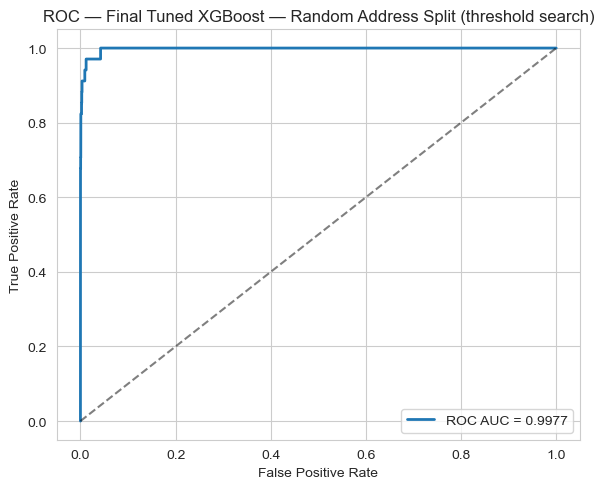

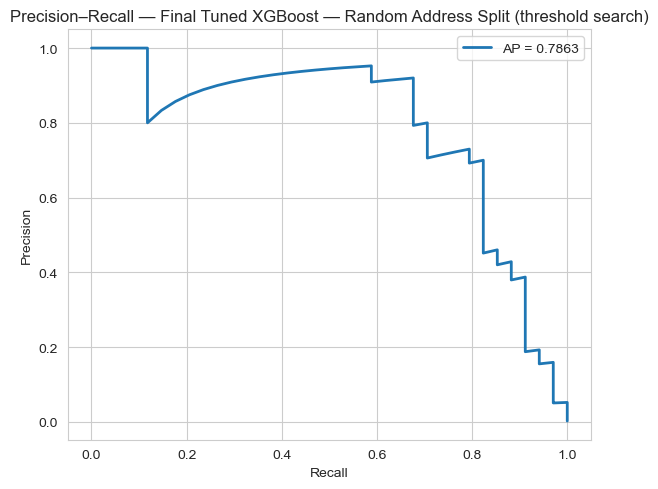

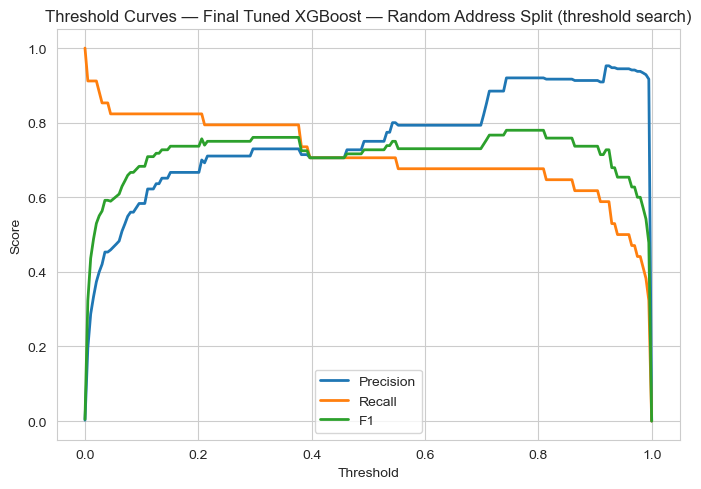

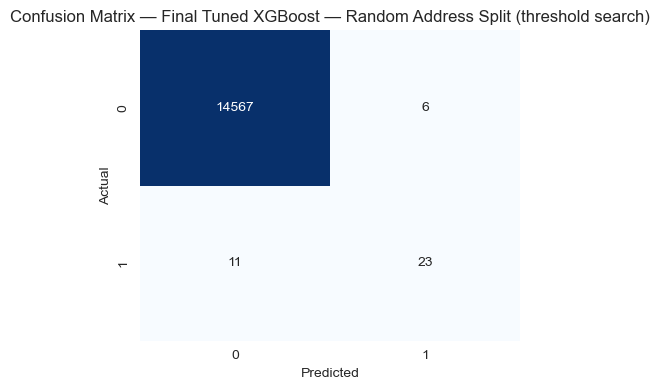

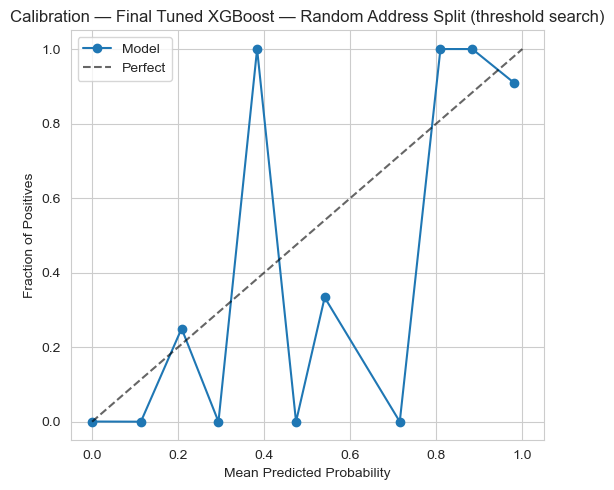

In [9]:
# ------------------------------------------------------------
# Prepare feature matrices for threshold tuning
# ------------------------------------------------------------
feature_cols = [c for c in features_trainval.columns if c != "Scam"]

# Train+Val features / labels (same ones used in tuning)
X_trainval = features_trainval[feature_cols].copy()
y_trainval = features_trainval["Scam"].astype(int).values

# Held-out test features / labels
X_test = features_test[feature_cols].copy()
y_test = features_test["Scam"].astype(int).values

# ------------------------------------------------------------
# Choose which tuned model to threshold
# ------------------------------------------------------------
final_model = best_random["XGBoost"]

# ------------------------------------------------------------
# Precision-first threshold tuning
#   - Sweep thresholds on validation (split from X_trainval / y_trainval)
#   - Require precision >= 0.75
#   - Among those, pick the highest-recall threshold (tie-breaker: F1)
#   - Evaluate and plot on the untouched test set
# ------------------------------------------------------------
best_threshold, val_sweep_df, test_metrics = me.precision_first_threshold_tuning(
    final_model,
    X_trainval,
    y_trainval,
    X_test,
    y_test,
    prec_min=0.75,
    name="Final Tuned XGBoost — Random Address Split (threshold search)",
)

In [10]:
os.makedirs("models", exist_ok=True)

# Bundle model + feature columns together
model_bundle = {
    "model": final_model,
    "feature_cols": feature_cols,
}

joblib_path = "models/best_random_split_model.pkl"
joblib.dump(model_bundle, joblib_path)

print(f"Saved random-split XGBoost model bundle to: {joblib_path}")

Saved random-split XGBoost model bundle to: models/best_random_split_model.pkl


### Final XGBoost Model & Threshold Tuning — Random Address Split

---

### 1. Threshold tuning makes the trade-off explicit

Using the tuned XGBoost as a **ranker**, we swept thresholds on the validation set and applied a simple rule:

> **Require precision ≥ 0.75, then maximize recall (tie-breaker: F1).**

This landed on **threshold = 0.66**, where validation performance is:
- Precision ≈ **0.78**
- Recall ≈ **0.67**
- F1 ≈ **0.72**

ROC AUC (~0.999) and Average Precision (~0.79) are unchanged by threshold choice, which confirms that we’re **only moving the cut-off**, not changing the underlying ranking power.

---

### 2. Final test performance: high lift over a tiny base rate

On the held-out test set (scam base rate ≈ **0.23%**), the tuned XGBoost at threshold 0.66 delivers:

- **Precision:** 0.79  
- **Recall:** 0.68  
- **F1:** 0.73  
- **ROC AUC:** 0.998  
- **Average Precision:** 0.79  

So when the model flags an address as “scam,” it’s **~80% likely to be correct**—roughly **300× better** than random guessing at the base rate.

---

### 3. Confusion matrix: few alerts, most of them real

At the chosen threshold, the test confusion matrix is:

- True negatives: **14,567**  
- False positives: **6**  
- False negatives: **11**  
- True positives: **23**

In practice, that means:

- The model raises **very few alerts** (29 out of ~14.6K clean addresses + 34 scams).
- When it *does* alert, about **4 out of 5** alerts are real scams.
- It still catches **~2/3 of all scams** despite this conservative setting.

This matches a **precision-first triage** use case: analysts get a short, high-quality queue of suspicious addresses.

---

### 4. Validation → test generalization is stable

Validation and test metrics at threshold 0.66 are nearly identical  
(precision 0.78 → 0.79, recall 0.67 → 0.68, F1 0.72 → 0.73), suggesting:

- No obvious overfitting from either hyperparameter tuning or threshold tuning.
- The random address split + tuning pipeline is **internally consistent**: choices made on validation transfer cleanly to the unseen test set.

---

### 5. Limitations and how we’d adapt in production

- The number of scams is tiny (27 in validation, 34 in test), so each misclassified address moves the metrics a lot; confidence intervals are wide.
- This is an **optimistic scenario**: train and test share the same time period and distribution.

In a production system, we would:

- Re-tune the **threshold on a time-ordered validation slice** or on recent data.
- Consider **multiple operating points** (e.g., a lower threshold for a broad “watchlist” vs. a higher one for “urgent manual review”).

## 8. Pickle the Best Model

In [11]:
os.makedirs("models", exist_ok=True)

# Bundle model + feature columns together
model_bundle = {
    "model": final_model,
    "feature_cols": feature_cols,
}

joblib_path = "models/best_random_split_model.pkl"
joblib.dump(model_bundle, joblib_path)

print(f"Saved random-split XGBoost model bundle to: {joblib_path}")

Saved random-split XGBoost model bundle to: models/best_random_split_model.pkl


## 9. Summary — What This Random Split Experiment Tells Us

This notebook answers a specific question:

> **How well can we separate scam vs. non-scam addresses when train and test come from the same distribution (no time drift)?**

Key points:

- Under a **random address split**, the engineered features are **very strong**: tuned XGBoost reaches ROC AUC ≈ 0.998 and AP ≈ 0.79.
- With a **precision-first threshold** (0.66), the final model:
  - Flags **very few addresses**,  
  - Is right ~**80%** of the time when it flags a scam,  
  - Still catches about **two-thirds** of all scams.
- Hyperparameter tuning and threshold tuning are **stable**: validation choices generalize cleanly to the test set.
- Perfect train scores for the tree models reflect **rare events + flexible models**, not a broken pipeline.

Most importantly:

> This notebook represents an **upper bound under stable conditions**.  
> The time-based notebook shows what happens when we relax that assumption and confront **distribution shift over time**.

Together, the two experiments give a more complete picture:
- **Here:** “What’s the best we can do when past and future look the same?”  
- **Time-split notebook:** “What survives when the future starts to look different from the past?”